In [1]:
import numpy as np
import matplotlib.pyplot as plt
from monte_carlo import *
from scipy import stats
%matplotlib inline

# Plots
This notebook contains combined plots to highlight the behavior of the Monte Carlo Methods. It uses some of the same plotting routines as are used in the Monte Carlo Intodruction.

In [2]:
def plot_rms(f, true_value, Ns=range(10, 1000, 100), iterations=1, methods=[], plot_fit=False):
    """ Plot RMS of deviations and RM of predicted variances. """
    if len(methods) == 0:
        raise ValueError("Need to provide at least one method.")
        
    Ns = np.array(Ns)
    # temporarily store the results of the methods in each iteration
    iteration_errors = np.empty(iterations)
    iteration_estimates = np.empty(iterations)
    
    for m, method in zip(range(len(methods)), methods):
        # store results for each sample size in Ns
        mean_vars = np.empty(len(Ns))
        rms = np.empty(len(Ns))
        
        for i, N in zip(range(len(Ns)), Ns):
            for j in range(iterations):
                iteration_estimates[j], iteration_errors[j] = method(f, N)
            # compute means
            mean_vars[i] = np.mean(iteration_errors**2)
            rms[i] = np.mean((iteration_estimates-true_value)**2)

        sqrt_mean_vars = np.sqrt(mean_vars)
        rms = np.sqrt(rms)
        
        if plot_fit:
            fit = np.polyfit(np.log(Ns), np.log(rms), 1)
            plt.loglog(Ns, np.exp(np.poly1d(fit)(np.log(Ns))), label="Fit, power %.2f"%fit[0])

        name = method.method_name if hasattr(method, 'method_name') else "Method %d"%i
        plt.loglog(Ns, sqrt_mean_vars, ".", label="predicted (%s)"%name, color="C%d"%m)
        plt.loglog(Ns, rms, "x", label="RMS deviations", color="C%d"%m)
        
    plt.xlabel("N")
    plt.legend(loc="best")
    plt.grid(True, which="both")

def plot_distribution(fn, true_val, N, iterations, method, bins=20, name="", alpha=1):
    """ Plot the distribution of estimates and the predicted Gaussian.
    
    For the variance of the Gaussian, use the mean of variances obtained from the
    returned values of the method.
    
    Args:
        N: Number of function evaluatios to be passed to method.
        iterations: Number of estimates to compute with method, choose bins accordingly.
        bins: Number of bins for the histogram of computed estimates.
        alpha: Plot histogram with alpha value, useful if comparing multiple distributions.
        name: Use in label for the plot, useful if comparing multiple distributions.
    """
    values = np.empty(iterations)
    mean_var = 0
    
    for i in range(iterations):
        values[i], var = method(fn, N)
        mean_var += var**2 / iterations
        
    plt.hist(values, bins=bins, normed=True, label="Actual " + name, alpha=alpha)
    
    x = np.linspace(true_val-4*np.sqrt(mean_var), true_val+4*np.sqrt(mean_var), 1000)
    # the normal distribution the estimate is predicted to follow
    dist = lambda x: stats.norm.pdf((x-true_val)/np.sqrt(mean_var))/np.sqrt(mean_var)
    plt.plot(x, dist(x), label="Predicted " + name)
    
    # config
    plt.grid(True)
    plt.legend(loc="best")
    return binwise_chi2(dist, values, bins=bins)

In [3]:
# The same test functions as used in the introduction

# periodic sin in 1 dimension
sin_1d = lambda x: np.sin(2*np.pi*x)
# periodic sin in any dimension; true integral value is 0
sin_nd = lambda *x: np.prod([sin_1d(xi) for xi in x], axis=0)

sqrtx_inv = lambda *x: np.sqrt(1/np.prod(x, axis=0))
sqrtx_inv_trueval = lambda dim: 2**dim  # true integral value depends on dimension

# A more complicated test function
tf_a = 16
tf_b = 1/.2**2
def osc(x):
    return x**2*np.cos(tf_a*np.pi*x/.2)**2*tf_b
def bound(a, x, b):
    return (x>a)*(x<=b)
def test_function(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
test_function_true_value = 2*.0333531 + .2

# corresponding channels
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/70/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/70/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptReject(p1, 3)
sampling2 = AcceptReject(p2, 2)
sampling3 = AcceptReject(p3, 3.5)

## Plotting the plain Monte Carlo estimates
This plot shows the distributions of plain Monte Carlo integration of a square integrable and a not square integrable function.

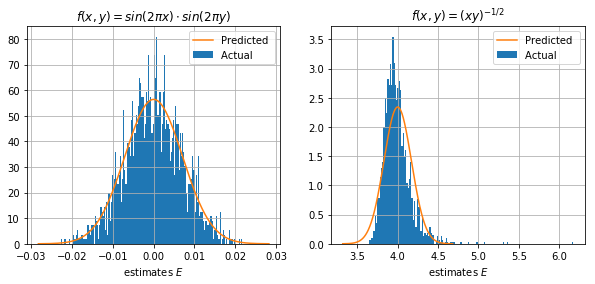

1.111067699402189 7413431582.761037


In [4]:
# Plot errors for sine and 1/sqrt(x) in any dimension
dim = 2
it = 2000  # number of iterations for the histogram
bins = 160  # number of bins for the histograms
N = 5000   # number of function evaluations

plt.figure(figsize=(10,4))
plt.tight_layout()
plt.subplot(121)
plt.title(r"$ f(x, y) = sin(2 \pi x)\cdot sin(2 \pi y)$")
chi2_1 = plot_distribution(sin_nd, 0, N=N, iterations=it, method=MonteCarloPlain(dim), bins=bins)
plt.xlabel("estimates $E$")

plt.subplot(122)
plt.title(r"$ f(x, y) = (xy)^{-1/2} $")
chi2_2 = plot_distribution(sqrtx_inv, sqrtx_inv_trueval(dim), N=N, iterations=it, method=MonteCarloPlain(dim), bins=bins)
plt.xlabel("estimates $E$")
plt.show()

print(chi2_1, chi2_2)

## Plotting the deviations of importance sampling
The integrand is the same test function as before, the deviations (and predicted standard deviations) are showin in a log-log plot, using the plot_rms method introduced previously.

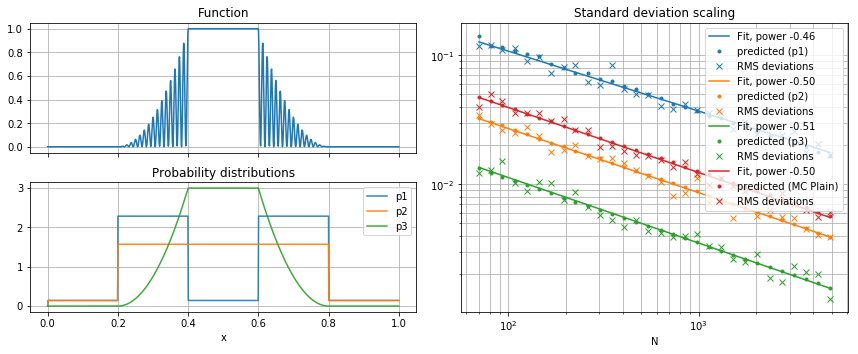

In [6]:
# compare importance sampling to the stratified boxing from before
plt.figure(figsize=(12,5))
ax = plt.subplot2grid((2, 2), (0, 0))
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
ax.tick_params(labelbottom='off') 
plt.grid()

plt.subplot2grid((2, 2), (1, 0))
plt.title("Probability distributions")
plt.plot(x, p1(x), label="p1", alpha=.9)
plt.plot(x, p2(x), label="p2", alpha=.9)
plt.plot(x, p3(x), label="p3", alpha=.9)
plt.legend()
plt.xlabel("x")
plt.grid()

plt.subplot2grid((2, 2), (0, 1), rowspan=2)
plt.title("Standard deviation scaling")
Ns = np.logspace(np.log10(70), 2*np.log10(70), 30, dtype=np.int)
plot_rms(test_function, test_function_true_value, iterations=40, Ns=Ns, 
         methods=[MonteCarloImportance(sampling=sampling1, pdf=p1, name="p1"),
                  MonteCarloImportance(sampling=sampling2, pdf=p2, name="p2"),
                  MonteCarloImportance(sampling=sampling3, pdf=p3, name="p3"),
                  MonteCarloPlain()], plot_fit=True)
plt.tight_layout(True)
plt.show()

## Plot the behavior of the deviatinos of multi-channel Monte Carlo
The deviations do not lie on a line in the log-log plot because the prefactor in the scaling is reduced.
Only in the limit is the scaling like $\sqrt{1/N}$ again.

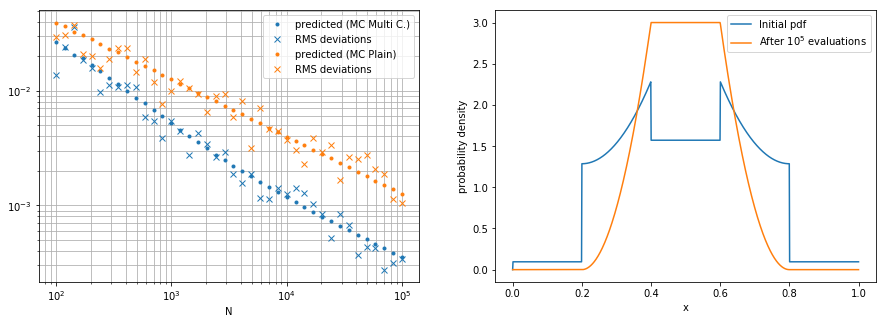

In [7]:
# use on test_function with the three probability distributions from before
channels = Channels([sampling1, sampling2, sampling3], [p1, p2, p3])

mcmci = MonteCarloMultiImportance(channels).get_interface_ratios(sub_sample_size=100, r1=0, r2=1, r3=0)

plt.figure(figsize=(15, 5))
plt.tight_layout()
ax2 = plt.subplot(122)
channels.plot_pdf(label="Initial pdf")

ax1 = plt.subplot(121)
# Ns = np.logspace(1+np.log10(5), 4, 20, dtype=np.int)
Ns = np.logspace(2, 5, 40, dtype=np.int)
plot_rms(test_function, test_function_true_value, Ns=Ns, iterations=10, 
               methods=[mcmci, MonteCarloPlain()])
plt.sca(ax2)
channels.plot_pdf(label="After $10^5$ evaluations")
plt.xlabel("x")
plt.ylabel("probability density")
plt.legend(loc=1)

plt.show()

## Inspecting the statistics of a local Markov Chain random walk
If the proposal distributino in the Metropolis algorithm is very local, a large autocorrelation is introduced.

321.35439068003024


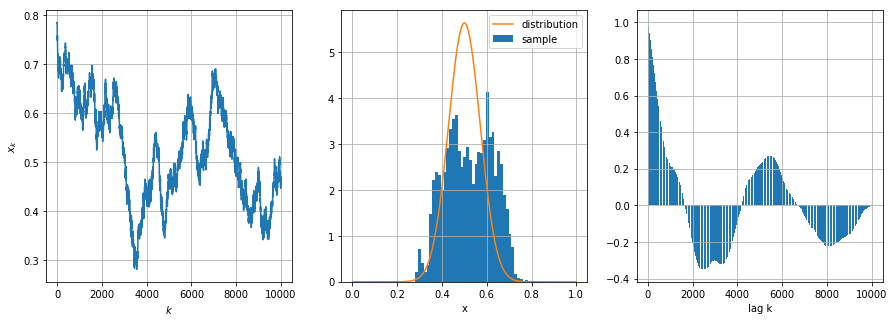

In [11]:
# example: local proposal and uniform pdf metropolis, proposal area 1/5th as large
bins = 40
delta = .015
proposal_generator = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
pdf = lambda x: np.exp(-(x-.5)**2/.01)
norm = 0.177245 # pdf / norm is normalized
metrop_gauss02 = Metropolis(.78, pdf, proposal_generator=proposal_generator)

r = metrop_gauss02(10000)[::1]
print(binwise_chi2(lambda x: pdf(x)/norm, r, bins=bins))

plt.figure(figsize=(15, 5))
# plt.title("time series plot")
plt.subplot(131)
plt.plot(r)
plt.xlabel("$k$")
plt.ylabel("$x_k$")
plt.grid()

# plot histogram
plt.subplot(132)
# plt.title("histogram")
plt.hist(r, bins=bins, normed=True, label="sample")
x = np.linspace(0, 1, 1000)
plt.grid()
plt.xlabel("x")
plt.plot(x, pdf(x)/norm, label="distribution")
plt.legend()

# plot autocorrelation
plt.subplot(133)
# plt.title("autocorrelation")
acov = auto_corr(r)
plt.bar(np.arange(len(acov)), acov)
plt.xlabel("lag k")
plt.grid()
plt.show()

## MC3 sampling of a modulated sin^2
Two settings of beta illustrate the impact of that parameter on the sample.

6.8964113397301885
61.12983930049601


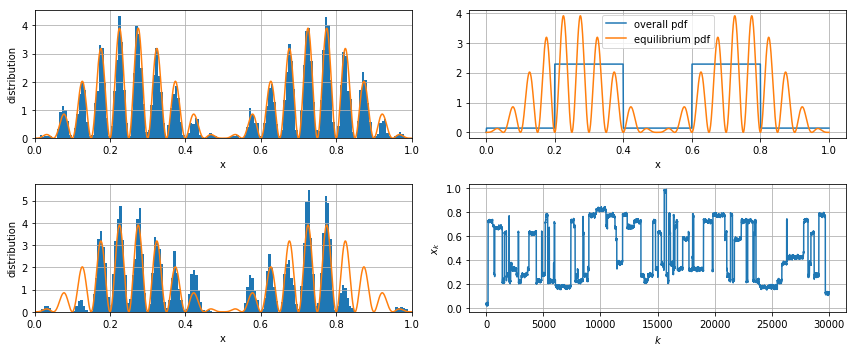

In [13]:
bins = 150

fn = lambda x: np.sin(2*np.pi*x)**2 * np.sin(10*2*np.pi*x)**2
mc3 = MC3(1, Channels([sampling1, sampling2, sampling3], [p1, p2, p3]), fn, delta=.01, initial_value=.5)
res = mc3(([], [500]*40, []), 30000, beta=0.6)
# beta = 1: only importance sampling
print(binwise_chi2(lambda x: fn(x)/mc3.integral, res, bins=bins))

plt.figure(figsize=(12,5))
plt.subplot(221)
plt.hist(res, normed=True, bins=bins)
plt.xlim(0, 1)
x = np.linspace(0, 1, 1000)
plt.plot(x, fn(x)/mc3.integral)
plt.grid()
plt.xlabel("x")
plt.ylabel("distribution")

plt.subplot(222)
mc3.channels.plot_pdf(label="overall pdf")
plt.plot(x, fn(x)/mc3.integral, label="equilibrium pdf")
plt.grid()
plt.xlabel("x")
plt.legend()

##### sample using more local updates
res = mc3.sample(30000, beta=0.01)
# beta = 1: only importance sampling
print(binwise_chi2(lambda x: fn(x)/mc3.integral, res, bins=bins))

plt.subplot(223)
plt.hist(res, normed=True, bins=bins)
plt.xlim(0, 1)
x = np.linspace(0, 1, 1000)
plt.plot(x, fn(x)/mc3.integral)
plt.grid()
plt.xlabel("x")
plt.ylabel("distribution")

plt.subplot(224)
plt.plot(res)
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$x_k$")
plt.tight_layout()

plt.show()